# Deutsch-Josza Algorithm

In [2]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

from qiskit.aqua import QuantumInstance
from qiskit.aqua import run_algorithm
from qiskit.aqua.algorithms import DeutschJozsa
from qiskit.aqua.components.oracles import TruthTableOracle

# import basic plot tools
from qiskit.tools.visualization import plot_histogram
q_backend = BasicAer.get_backend('qasm_simulator')

ImportError: cannot import name 'run_algorithm' from 'qiskit.aqua' (e:\developmentenvironments\anaconda3\envs\qiskit19_env\lib\site-packages\qiskit\aqua\__init__.py)

## Introduction

The Deutsch-Josza algorithm was the first example of a quantum algorithm which performs better than the best classical algorithm. It showed that there can be advantages in using a quantum computer as a computational tool for a specific problem.

In 1985, David Deutsch found a quantum algorithm to answer in only one evaluation of $f$. 
In 1992, David Deutsch and Richard Josza extended this to the case of $N$ input bits ($2^N$ possible input values)


The algorithm solves the following problem:

Let $f$ be a function from $\{0,1\}$ to $\{0,1\} :  f : x \in \{0,1\} ⟼ \{0,1\}$, it can be either *constant* or *balanced*. If one wants to know if $f$ is contant or balanced, a classical algorithm needs to calculate the value of $f$ for both possible inputs.

If $U_{f}$ : $f(0) = f(1)  \mapsto CONSTANT Function$ and <br>
If $U_{f}$ : $f(0) \ne f(1)\mapsto BALANCED Function$

Explanation: We are given a function $f: \{0,1\} \rightarrow \{0,1\} $ which takes $0$ or $1$ as input and outputs $0$ or $1$. The function itself can be of arbitrary complexity, but the only requirement is that it takes a bit as input and outputs another bit. Given two different inputs $x$ and $y$, check if the function $f(x)$ is equal to $f(y)$.

A classical algorithm solves the problem by evaluating $f(x)$ and $f(y)$ separately and then compare the results. This requires at least two calls to the function $f$. 

The Deutsch-Josza algorithm can solve this problem in only one step!

## Simple Qiskit Implementation

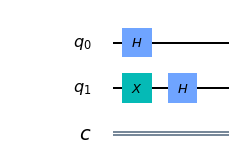

In [6]:
#Create Input Circuit
qc_input = QuantumCircuit(2,1)
qc_input.x([1])
qc_input.h([0,1])
qc_input.draw('mpl')

In [15]:
#Let us see what this input circuit returns in qubit 0
qc_temp = QuantumCircuit(2,1)
#Append input circuit
qc_temp.append(qc_input,[0,1])

#We are measuring only the first qubit
qc_temp.measure([0],[0])
results = execute(qc_temp,q_backend, shots=1024).result()
print(results.get_counts())
#It returns both 0 and 1 on qubit 0

{'0': 485, '1': 539}


### Explanation: Input Circuit

Let us calculate the 2 qubit system state from left to right: 
\begin{equation}
|\psi_1⟩ = |0⟩\otimes|1⟩
\end{equation}

Apply Hadamard:
\begin{equation}
|\psi_2⟩ = \frac{1}{\sqrt{2}}(|0⟩+|1⟩) \otimes \frac{1}{\sqrt{2}}(|0⟩-|1⟩)
\end{equation}

Regroup the $\frac{1}{\sqrt{2}}$ to the left, and distribute $(|0⟩-|1⟩)$ : 

\begin{equation}
|\psi_2⟩ = \frac{1}{2} \left(|0⟩ \otimes (|0⟩-|1⟩) + |1⟩ \otimes (|0⟩-|1⟩) \right)
\end{equation}

Factor left qubit with value $|x⟩$ and sum for $x=0$ to $x=1$

\begin{equation}
|\psi_2⟩ = \frac{1}{2}\sum_{x=0}^{x=1}|x⟩ \otimes (|0⟩-|1⟩)
\end{equation}

\begin{equation}
|\psi_2⟩ = \frac{1}{2}\sum_{x=0}^{x=1}(|x⟩\otimes|0⟩-|x⟩\otimes|1⟩)
\end{equation}

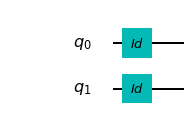

In [16]:
#Uf0 implements a constant function
Uf0 = QuantumCircuit(2, name='Uf0')

#This implements the funtion
#Implement 1 : returns 0 
Uf0.iden([0,1])

#Uf0.to_instruction()
Uf0.draw(output='mpl')

In [17]:
#Let us see what Uf0 does to the input circuit
qc_temp = QuantumCircuit(2,1)
#Append input circuit
qc_temp.append(qc_input,[0,1])
#Append function circuit
qc_temp.append(Uf0,[0,1])

#We are measuring only the first qubit
qc_temp.measure([0],[0])
results = execute(qc_temp,q_backend, shots=1024).result()
print(results.get_counts())

{'0': 517, '1': 507}


### Explanation: After the Function

Now the states go through $U_f$, qubit 0 is unchanged, qubit 1 gets XORed with $f(x)$

\begin{equation}
|\psi_3⟩ = \frac{1}{2}\sum_{x=0}^{x=1}(|x⟩|0\oplus f(x)⟩-|x⟩|1\oplus f(x)⟩)
\end{equation}

Note :

- If $f(x) = 0$ then  $0\oplus f(x) = 0$ and $1\oplus f(x) = 1$

- If $f(x) = 1$ then $0\oplus f(x) = 1$ and $1\oplus f(x) = 0$  

Such that: 

- If $f(x) = 0$ then $|x⟩\otimes|0\oplus f(x)⟩- |x⟩\otimes|1\oplus f(x) ⟩ = |x⟩\otimes|0⟩-|x⟩\otimes|1⟩ =|x⟩\otimes(|0⟩-|1⟩$

- If $f(x) = 1$ then  $|x⟩\otimes|0\oplus f(x)⟩- |x⟩\otimes|1\oplus f(x) ⟩ = |x⟩\otimes|1⟩-|x⟩\otimes|0⟩ = -|x⟩\otimes(|0⟩-|1⟩$


Then both cases ($f(x) = 0$ and $f(x) = 1$) can be regrouped in: 

\begin{equation}
|x⟩\otimes|0\oplus f(x)⟩ - |x⟩|1 \oplus f(x) ⟩ = (-1)^{f(x)}|x⟩\otimes(|0⟩-|1⟩)
\end{equation}

Now we have 

\begin{equation}
|\psi_3⟩ = \frac{1}{2}\sum_{x=0}^{x=1}(-1)^{f(x)}|x⟩\otimes(|0⟩-|1⟩) 
\end{equation}

Then (moving $|0⟩-|1⟩)$ out of the summation):

\begin{equation}
|\psi_3⟩ =  \frac{1}{2}\left(\sum_{x=0}^{x=1}(-1)^{f(x)}|x⟩\right)\otimes(|0⟩-|1⟩
\end{equation}

And developping the sum:

\begin{equation}
|\psi_3⟩  = \frac{1}{2}\left((-1)^{f(0)}|0⟩ + (-1)^{f(1)}|1⟩\right)\otimes(|0⟩-|1⟩)
\end{equation}

### Function $U_{f_0}$ : $f_0(0) = f_0(1) = 0$ : CONSTANT (result = 0 )

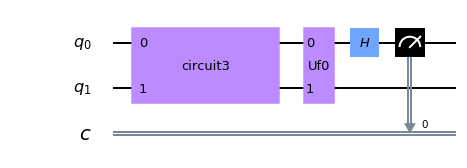

In [18]:
#This is the DJ algorithm implemenation
DJ = QuantumCircuit(2,1)
DJ.append(qc_input,[0,1])
DJ.append(Uf0,[0,1])
DJ.h([0])
DJ.measure([0],[0])
DJ.draw(output='mpl')

In [21]:
# define job, get results
job = execute(DJ,q_backend,shots=1024)
DJ_result = job.result()
print(DJ_result.get_counts())  

{'0': 1024}


### Explanation: After the Application of a Hadamard Gate

Now, getting to $|\psi_4⟩$, qubit 0 goes through Hadamard : 


\begin{equation}
|\psi_4⟩  = \frac{1}{2}\left((-1)^{f(0)}\frac{1}{\sqrt{2}}(|0⟩+|1⟩) + (-1)^{f(1)}\frac{1}{\sqrt{2}}(|0⟩-|1⟩)\right) \otimes (|0⟩-|1⟩)
\end{equation}

\begin{equation}
|\psi_4⟩ = \frac{1}{2\sqrt{2}}\left(\left((-1)^{f(0)}+(-1)^{f(1)}\right)|0⟩ + \left((-1)^{f(0)}-(-1)^{f(1)}\right)|1⟩\right) \otimes(|0⟩-|1⟩)
\end{equation}

Then we see that: 

- If $f(0) = f(1)$ then measuring qubit 0 results in $|0⟩$
- If $f(0) ≠ f(1)$ then measuring qubit 0 results in $|1⟩$

### Function $U_{f_1}$ : $f_1(0) = 0, f_1(1) = 1$ : BALANCED  (result  = 1)

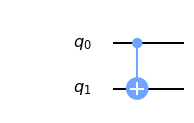

In [22]:
#Now we create a second function Uf1
Uf1 = QuantumCircuit(2, name='Uf1')
#build Uf1 here: 
Uf1.cx([0],[1])
Uf1.to_instruction()
Uf1.draw(output='mpl')

In [23]:
#Let us see what Uf1 does to the input circuit
qc_temp = QuantumCircuit(2,1)
#Append input circuit
qc_temp.append(qc_input,[0,1])
#Append function circuit
qc_temp.append(Uf1,[0,1])

#We are measuring only the first qubit
qc_temp.measure([0],[0])
results = execute(qc_temp,q_backend, shots=1024).result()
print(results.get_counts())
#This also gives 0 and 1, almost balanced # of times. But we do not know whether it returns 0 for 0 or 1 for a 0

{'0': 483, '1': 541}


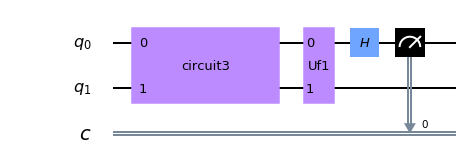

In [25]:
#This is the DJ algorithm implemenation
DJ = QuantumCircuit(2,1)
DJ.append(qc_input,[0,1])
DJ.append(Uf1,[0,1])
DJ.h([0])
DJ.measure([0],[0])
DJ.draw(output='mpl')

In [26]:
# define job, get results
job = execute(DJ,q_backend,shots=1024)
DJ_result = job.result()
print(DJ_result.get_counts())
#This time we get a 1, indicating thefunction Uf1 is a balanced function

{'1': 1024}


### Function $U_{f_2}$ : $f_2(0) = 1, f_2(1) = 0$ : BALANCED (result = 1)

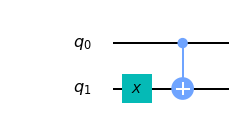

In [27]:
#This Uf2 function is supposed to return 1 for input 0 and 0 for 1
Uf2 = QuantumCircuit(2, name='Uf2')
# build Uf2 here: 
Uf2.x([1])
Uf2.cx([0],[1])
Uf2.to_instruction()
Uf2.draw(output='mpl')

In [28]:
#Let us see what Uf1 does to the input circuit
qc_temp = QuantumCircuit(2,1)
#Append input circuit
qc_temp.append(qc_input,[0,1])
#Append function circuit
qc_temp.append(Uf1,[0,1])

#We are measuring only the first qubit
qc_temp.measure([0],[0])
results = execute(qc_temp,q_backend, shots=1024).result()
print(results.get_counts())
#This also gives 0 and 1, almost balanced # of times. But we do not know whether it returns 0 for 0 or 1 for a 0

{'0': 536, '1': 488}


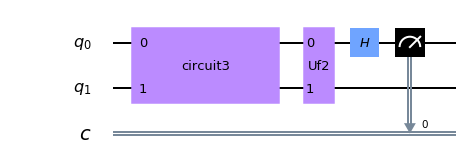

In [30]:
#This is the DJ algorithm implemenation
DJ = QuantumCircuit(2,1)
DJ.append(qc_input,[0,1])
DJ.append(Uf2,[0,1])
DJ.h([0])
DJ.measure([0],[0])
DJ.draw(output='mpl')

In [31]:
# define job, get results
job = execute(DJ,q_backend,shots=1024)
DJ_result = job.result()
print(DJ_result.get_counts())
#This time we get a 1, indicating thefunction Uf2 is a balanced function

{'1': 1024}


### Function $U_{f_3}$ : $f(0) = f(1) = 1$ : CONSTANT (result = 0)

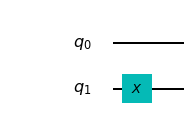

In [32]:
Uf3 = QuantumCircuit(2, name='Uf3')
# build Uf3 here: 
Uf3.x([1])
#Uf3.to_instruction()
Uf3.draw(output='mpl')

In [33]:
#Let us see what Uf1 does to the input circuit
qc_temp = QuantumCircuit(2,1)
#Append input circuit
qc_temp.append(qc_input,[0,1])
#Append function circuit
qc_temp.append(Uf3,[0,1])

#We are measuring only the first qubit
qc_temp.measure([0],[0])
results = execute(qc_temp,q_backend, shots=1024).result()
print(results.get_counts())
#This also gives 0 and 1, almost balanced # of times. But we do not know whether it returns 0 for 0 or 1 for a 0

{'0': 516, '1': 508}


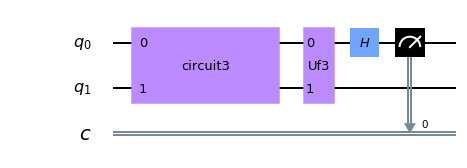

In [34]:
#This is the DJ algorithm implemenation
DJ = QuantumCircuit(2,1)
DJ.append(qc_input,[0,1])
DJ.append(Uf3,[0,1])
DJ.h([0])
DJ.measure([0],[0])
DJ.draw(output='mpl')

In [35]:
# define job, get results
job = execute(DJ,q_backend,shots=1024)
DJ_result = job.result()
print(DJ_result.get_counts())
#This time we get a 1, indicating thefunction Uf2 is a balanced function

{'0': 1024}


## Quantum Circuit for Deutsch-Josza Algorithm

The objective of this quantum algorithm is to solve the problem in only one step! 

The quantum circuit that implements the algorithm is the following.

<img src="images/deutsch2.jpeg"  width="300">

where $\text{F}$ is the function described by the action on a qubit $\lvert x \rangle$ as
$$ \lvert x \rangle \rightarrow (-1)^{f(x)} \lvert x \rangle $$

Now, let us go through the steps of the algorithm:

<ol>
    <li> The input qubit is initialized to the zero state 
    $$\lvert \psi_1 \rangle = \lvert 0 \rangle $$ </li>
    <li> Apply Hadamard on the qubit to get the state $$\lvert \psi_2 \rangle = \frac{1}{\sqrt{2}} \left(\lvert 0 \rangle + \lvert 1 \rangle \right)  $$ </li>
    <li> We make a query $\text{Q}_f$, 
    $$ \lvert \psi_3 \rangle = \frac{1}{\sqrt{2}} \left( (-1)^{f(0)} \lvert 0 \rangle + (-1)^{f(1)} \lvert 1 \rangle \right)  $$ 
   Thus, if $f(0) = f(1)$, (up to a global phase factor):
   $$ \lvert \psi_3 \rangle = \frac{(-1)^{f(0)}}{\sqrt{2}} \left(  \lvert 0 \rangle + \lvert 1 \rangle \right) $$
    
   while if $f(0) \neq f(1)$, (up to a global phase factor):
   $$ \lvert \psi_3 \rangle = \frac{(-1)^{f(0)}}{\sqrt{2}} \left(  \lvert 0 \rangle - \lvert 1 \rangle \right) $$
   </li>
    
   <li> Apply Hadamard again. If  $f(0) = f(1)$:
        $$ \lvert \psi_4 \rangle = (-1)^{f(0)} \lvert 0 \rangle $$
        
   while if  $f(0) \neq f(1)$:
        $$ \lvert \psi_4 \rangle = (-1)^{f(0)} \lvert 1 \rangle $$
   </li>
   <li> Measuring the qubit will either give:
        $$ "0", \; \; \text{if} \; f(0) = f(1)$$
        $$ "1", \; \; \text{if} \; f(0) \neq f(1)$$
   </li>
</ol>

Therefore by looking at the value of the measured qubit, we can tell whether $f(0) = f(1)$ or $f(0) \neq f(1)$ by solving the problem with only one query to the function $\text{Q}_f$.

Compared to the classical algorithm, the quantum algorithm takes half the number of steps. This might not seem much of an advantage but it is a first steps in proving the usefulness of quantum computation.

Also, if the input to the function is not just one bit but an $n$ bit string, it can be proven that the quantum algorithm will take $\frac{n}{2}$ queries to the function (just run the algorithm on a pair of bits) rather than the $n$ steps needed for a classical algorithm.

### Example

In Ref. [1], the Deutsch-Josza algorithm was implemented on a real device. However, in order to do it two qubits were used, one is used as ancilla. In this way, the query function $Q_f$ was realized. Let us see how it works.

<img src="images/deutsch_ex1.jpeg"  width="300">

<ol>
    <li> The first qubit is initialized to $|0\rangle$ and the second is initialized to $|1\rangle$.
    $$\lvert \psi_1 \rangle = \lvert 0\rangle \lvert 1 \rangle_a $$ </li>
    <li> Apply Hadamard on both qubits $$\lvert \psi_2 \rangle = \frac{1}{\sqrt{2}} \left(\lvert 0 \rangle + \lvert 1 \rangle \right) \frac{1}{\sqrt{2}} \left(\lvert 0 \rangle_a - \lvert 1 \rangle_a \right) = \frac{1}{2}\left(\lvert 0 \rangle \lvert 0 \rangle_a  - \lvert 0 \rangle \lvert 1 \rangle_a + \lvert 1 \rangle \lvert 0 \rangle_a - \lvert 1 \rangle \lvert 1 \rangle_a \right)   $$ </li><p></p>
    <li> The query function $\text{Q}_f$ can be implemented in different ways. Let us consider the case where $f(0) = 0$ and $f(1)=1$, thus $Q_f = CX_{12}$ 
    $$ \lvert \psi_3 \rangle = \frac{1}{2} \left(\lvert 0 \rangle \lvert 0 \oplus 0 \rangle_a  - \lvert 0 \rangle \lvert 1 \oplus 0 \rangle_a + \lvert 1 \rangle \lvert 0 \oplus 1 \rangle_a - \lvert 1 \rangle \lvert 1 \oplus 1 \rangle_a \right) \\
    = \frac{1}{2}\left(\lvert 0 \rangle \lvert 0 \rangle_a  - \lvert 0 \rangle \lvert 1 \rangle_a + \lvert 1 \rangle \lvert 1 \rangle_a - \lvert 1 \rangle \lvert 0 \rangle_a \right)  $$ 
   Thus:
    $$ \lvert \psi_3 \rangle = \frac{1}{\sqrt{2}} \left(\lvert 0 \rangle - \lvert 1 \rangle \right) \frac{1}{\sqrt{2}} \left(\lvert 0 \rangle_a - \lvert 1 \rangle_a \right) $$
   <li> Apply Hadamard on both qubits again:
        $$ \lvert \psi_4 \rangle = \lvert 1 \rangle \lvert 1 \rangle_a $$
   </li><p></p>
    <li> Measuring the first qubit will give $"1"$, therefore $ f(0) \neq f(1)$
    </li>
</ol>

## Qiskit Implementation

We now implement the Deutsch-Josza algorithm with Qiskit by first preparing the environment.

In [2]:
# Creating registers
qr = QuantumRegister(2)
# classical registers for recording the measurement on qr
cr = ClassicalRegister(2)

deujosCircuit = QuantumCircuit(qr, cr)
barriers = True

# initialize the ancilla qubit in the |1> state
deujosCircuit.x(qr[1])

# Apply barrier 
if barriers:
    deujosCircuit.barrier()

# Apply Hadamard gates before querying the oracle
deujosCircuit.h(qr[0])    
deujosCircuit.h(qr[1])    
    
# Apply barrier 
if barriers:
    deujosCircuit.barrier()

# Query the oracle 
deujosCircuit.cx(qr[0], qr[1])

# Apply barrier 
if barriers:
    deujosCircuit.barrier()

# Apply Hadamard gates after querying the oracle
deujosCircuit.h(qr[0])    
deujosCircuit.h(qr[1])    

# Measure the input qubit
deujosCircuit.measure(qr[0], cr[0])

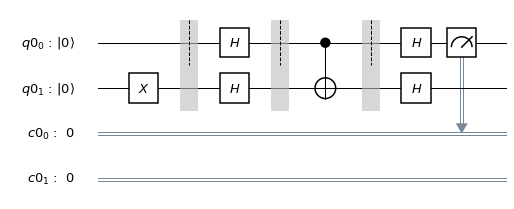

In [3]:
deujosCircuit.draw(output='mpl')

## Experiment with Simulators

We can run the above circuit on the simulator. 

c0 = 1 (1024 shots)


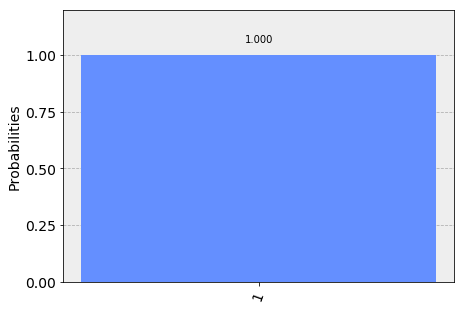

In [4]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(deujosCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()

# categorize answers to c0 = 0 and c0 = 1
answer_c0 = {}
for c1c0 in answer:
    print('c0 = {} ({} shots)'.format(c1c0[1], answer[c1c0]))
    
    if c1c0[1] in answer_c0:
        answer_c0[c1c0[1]] += answer[c1c0]
    else:
        answer_c0[c1c0[1]] = answer[c1c0]

plot_histogram(answer_c0)

As we can see, the only measured value is $c0 = 1$, indicating that $f(0) \neq f(1)$.

## Experiment with Real Devices

We can run the circuit on the real device as shown below.

In [3]:
# Load our saved IBMQ accounts and get the least busy backend device that we are allowed to use
IBMQ.load_accounts()
IBMQ.backends()
backend_lb = least_busy(IBMQ.backends(simulator=False))
print("Least busy backend: ", backend_lb)

AttributeError: 'IBMQFactory' object has no attribute 'load_accounts'

In [6]:
# run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

backend = backend_lb
shots = 1024
job_exp = execute(deujosCircuit, backend=backend, shots=shots)

job_monitor(job_exp, interval = 2)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

c0 = 1 (813 shots)
c0 = 0 (211 shots)
{'1': 813, '0': 211}


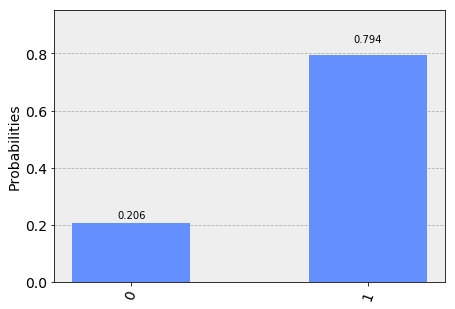

In [7]:
# get the results from the computation
results = job_exp.result()
answer = results.get_counts(deujosCircuit)

# categorize answers to c0 = 0 and c0 = 1
answer_c0 = {}
for c1c0 in answer:
    print('c0 = {} ({} shots)'.format(c1c0[1], answer[c1c0]))
    if c1c0[1] in answer_c0:
        answer_c0[c1c0[1]] += answer[c1c0]
    else:
        answer_c0[c1c0[1]] = answer[c1c0]

# show answers
print(answer_c0)
plot_histogram(answer_c0)

As we can see, most of the results are for $c0 = 1$, indicating that $f(0) \neq f(1)$. The results with $c0 = 0$ occur due to errors in the quantum computation. 

## References

[1] R. Gulde, M. Riebe, G.P.T. Lancaster, C. Becher, J. Eschner, H. Haffner and. F. Schmidt-Kaler, I.L. Chuang, and R. Blatt. Implementation of the Deutsch-Jozsa algorithm on an ion-trap quantum computer. Nature, 421:48 (2003).


## Another Implementation

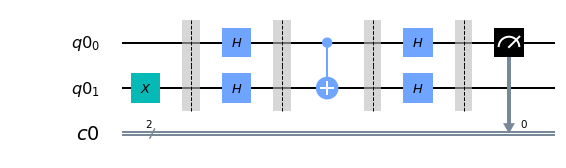

In [10]:
'''
    Deutsch-Jozsa Algorithm

    Consider a function f(x) that takes as input n-bit strings x and returns 0 or 1. Suppose we are
    promised that f(x) is either a constant function that takes the same value c in {0,1} on all
    inputs x, or a balanced function that takes each value 0 and 1 on exactly half of the inputs. 
    The goal is to decide whether f is constant or balanced by making as few function evaluations 
    as possible. Classically, it requires 2^{n-1}+1 function evaluations in the worst case. Using 
    the Deutsch-Jozsa algorithm, the question can be answered with just one function evaluation.
    
    Deutsch's algorithm is the simpler case of Deutsch-Jozsa Algorithm which has a function f(x) 
    which takes 1-bit as input.

    Source: https://github.com/Qiskit/ibmqx-user-guides/blob/master/rst/full-user-guide/004-Quantum_Algorithms/080-Deutsch-Jozsa_Algorithm.rst

'''
qr = QuantumRegister(2)  # Initialize two qubits
cr = ClassicalRegister(2)  # Initialize two bits for record measurements
circuit = QuantumCircuit(qr, cr)

circuit.x(qr[1])  # initialize the ancilla qubit in the |1> state

circuit.barrier()

# First step of quantum algorithms - Prepare the superposition
# For superposition, we apply the Hadamard gate on both qubits
circuit.h(qr[0])
circuit.h(qr[1])

circuit.barrier()

# Oracle function
circuit.cx(qr[0], qr[1])

circuit.barrier()

# Apply Hadamard gates after querying oracle function
circuit.h(qr[0])
circuit.h(qr[1])

circuit.barrier()

# Measure qubit
circuit.measure(qr[0], cr[0])
circuit.draw('mpl')

In [11]:
# Run our circuit with local simulator
shots = 1024
results = execute(circuit, backend=q_backend, shots=shots).result()
answer = results.get_counts()
print("Simulator result")
for c1c0 in answer:
    print(f'c0 = {c1c0[1]} ({answer[c1c0]} shots)')
# C0 observed as 1 in 1024 shots
# It indicates f(0) != f(1)

Simulator result
c0 = 1 (1024 shots)


In [13]:
# Run our circuit with real devices
IBMQ.load_account()
backend_lb = least_busy(IBMQ.backends(simulator=False))
backend = backend_lb
shots = 1024
job_exp = execute(circuit, backend=backend, shots=shots)
job_monitor(job_exp, interval=2)
results = job_exp.result()
answer = results.get_counts(circuit)
print("Real Device Result")
for c1c0 in answer:
    print(f'c0 = {c1c0[1]} ({answer[c1c0]} shots)')
# As we can see in results, most of the results for C0 is 1
# It indicates f(0) != f(1)
# The results with C0 = 0 occur due to errors in the quantum computation.

ibmqfactory.load_account:WARNING:2020-04-24 14:26:33,500: Credentials are already in use. The existing account in the session will be replaced.


AttributeError: 'IBMQFactory' object has no attribute 'backends'

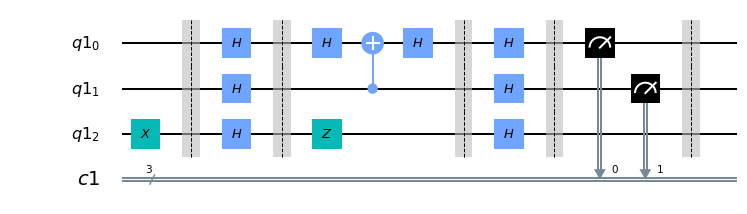

In [14]:
#For 3-Qubits
qr = QuantumRegister(3)  # Initialize qubits
cr = ClassicalRegister(3)  # Initialize bits for record measurements
circuit = QuantumCircuit(qr, cr)

circuit.x(qr[2])  # initialize the ancilla qubit in the |1> state

circuit.barrier()

# First step of quantum algorithms - Prepare the superposition
# For superposition, we apply the Hadamard gate on all qubits
circuit.h(qr[0])
circuit.h(qr[1])
circuit.h(qr[2])

circuit.barrier()

# Oracle function
circuit.h(qr[0])
circuit.cx(qr[1], qr[0])
circuit.z(qr[2])
circuit.h(qr[0])

circuit.barrier()

# Apply Hadamard gates after querying oracle function
circuit.h(qr[0])
circuit.h(qr[1])
circuit.h(qr[2])

circuit.barrier()

# Measure qubit
circuit.measure(qr[0], cr[0])
circuit.measure(qr[1], cr[1])

circuit.barrier()
circuit.draw('mpl')

In [15]:
# Run our circuit with local simulator
shots = 1024
results = execute(circuit, backend=q_backend, shots=shots).result()
answer = results.get_counts()
print("Simulator result")
for c2c1c0 in answer:
    print(f"{c2c1c0} is observed in {answer[c2c1c0]} times")
# If we measure |0>^n, then f is constant, other results tell us that f is balanced


Simulator result
000 is observed in 219 times
001 is observed in 263 times
011 is observed in 275 times
010 is observed in 267 times


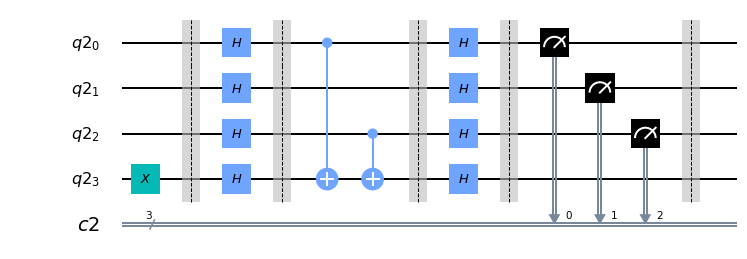

In [16]:
#For n-qubit
n = 3
oracle = "b"  # b for balanced, c for constant

if oracle == "b":
    b = 5
if oracle == "c":
    c = 0  # or 1

qr = QuantumRegister(n+1)  # Initialize qubits
cr = ClassicalRegister(n)  # Initialize bits for record measurements
circuit = QuantumCircuit(qr, cr)

circuit.x(qr[n])  # initialize the ancilla qubit in the |1> state

circuit.barrier()

# First step of quantum algorithms - Prepare the superposition
# For superposition, we apply the Hadamard gate on all qubits
circuit.h(qr)

circuit.barrier()

# Oracle function
if oracle == "c":  # constant, return c
    if c == 1:
        circuit.x(qr[n])
    else:
        circuit.iden(qr[n])
else:  # balanced, return inner product of input with b
    for i in range(n):
        if (b & (1 << i)):
            circuit.cx(qr[i], qr[n])

circuit.barrier()

# Apply Hadamard gates after querying oracle function
circuit.h(qr)

circuit.barrier()

# Measure qubits
for i in range(n):
    circuit.measure(qr[i], cr[i])

circuit.barrier()
circuit.draw('mpl')

In [17]:
# Run our circuit with local simulator
shots = 1024
results = execute(circuit, backend=q_backend, shots=shots).result()
answer = results.get_counts()
print("Simulator result")
print(answer)
# If we measure |0>^n, then f is constant, other results tell us that f is balanced


Simulator result
{'101': 1024}


## The Real Way of Using the Algorithm

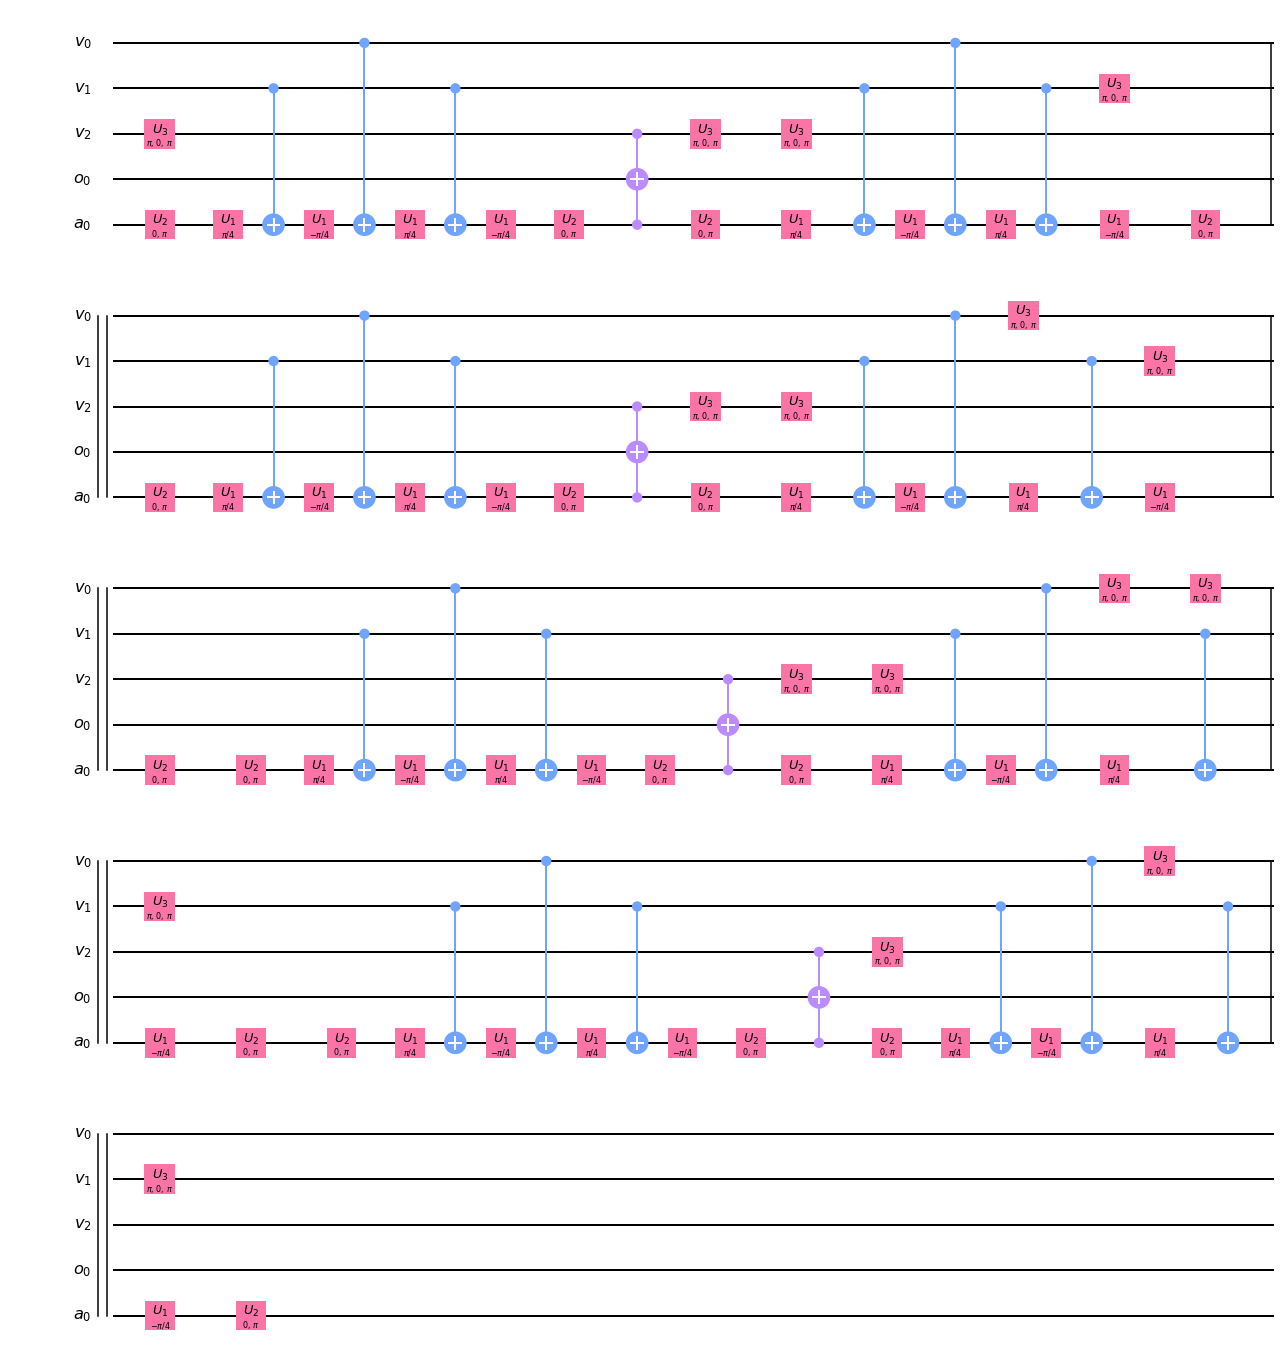

In [3]:
#Now let us create a bit string, based on that we use an Oracle to create a circuit
#We have a bitstring, with which we will create an oracle
bitstr = '11110000'
oracle = TruthTableOracle(bitstr)

#An oracle is nothing but a readymade circuit given by the algorithm
oracle.circuit.draw(output='mpl')

In [6]:
#Now we run the Deutsch-Jozsa algorithm from qiskit aqua - created on this oracle
dj = DeutschJozsa(oracle)
result = dj.run(QuantumInstance(q_backend, shots=1024))
print('The truth table {} represents a {} function.'.format(bitstr, result['result']))

The truth table 11110000 represents a balanced function.


In [8]:
#This is the parametric method to run the identical operation
bitstr = '11110000'
params = {
    'problem': {
        'name': 'functionevaluation',
    },
    'algorithm': {
        'name': 'DeutschJozsa'
    },
    'oracle': {
        'name': 'TruthTableOracle',
        'bitmaps': [bitstr]
    },
    'backend': {
        'shots': 1024,
    },
}

result_dict = run_algorithm(params, backend=q_backend)
print('The truth table {} represents a {} function.'.format(bitstr, result_dict['result']))

E:\DevelopmentEnvironments\Anaconda3\envs\qiskit_env\lib\site-packages\qiskit\aqua\qiskit_aqua.py:119: DeprecationWarning: Declarative API will be removed next Aqua release. Please construct classes and call appropriate methods.
  warnings.warn(aqua_globals.CONFIG_DEPRECATION_MSG, DeprecationWarning)


The truth table 11110000 represents a balanced function.


In [9]:
#We may create the bit string this way as well
bitstr = '1' * 32
oracle = TruthTableOracle(bitstr)
dj = DeutschJozsa(oracle)

result = dj.run(QuantumInstance(q_backend, shots=1024))
print('The truth table {} represents a {} function.'.format(bitstr, result['result']))

The truth table 11111111111111111111111111111111 represents a constant function.
